# Advection
## 1D linear advection

\begin{align*}
   \frac{\partial q}{\partial t}+c\frac{\partial q}{\partial x} = 0,
\end{align*}

In [1]:
import numpy as np
# from numpy import fft
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
sys.path.append('../')
from CODE_nm_calculus import nm

Setting up default parameters and initial field

In [2]:
L    = 10
N    = 400
Tlen = 100
X    = np.linspace(-L,L,N+1)[0:-1]
Dx   = X[1]-X[0]
Dt   = 0.1*Dx
T    = np.arange(0,Tlen+Dt,Dt)
c    = 0.2

Q      = np.zeros((len(T),len(X)))
Q[0,:] = np.exp(-5*X**2)

Integrating

In [3]:
def fFft(t,Q):
    Y = -c*nm.NDiffFft(X,Q)
    return Y

for t in range (len(T)-1):
    Q[t+1,:] = nm.NIntgRk4(T[t],Q[t,:],Dt,fFft)

Plotting

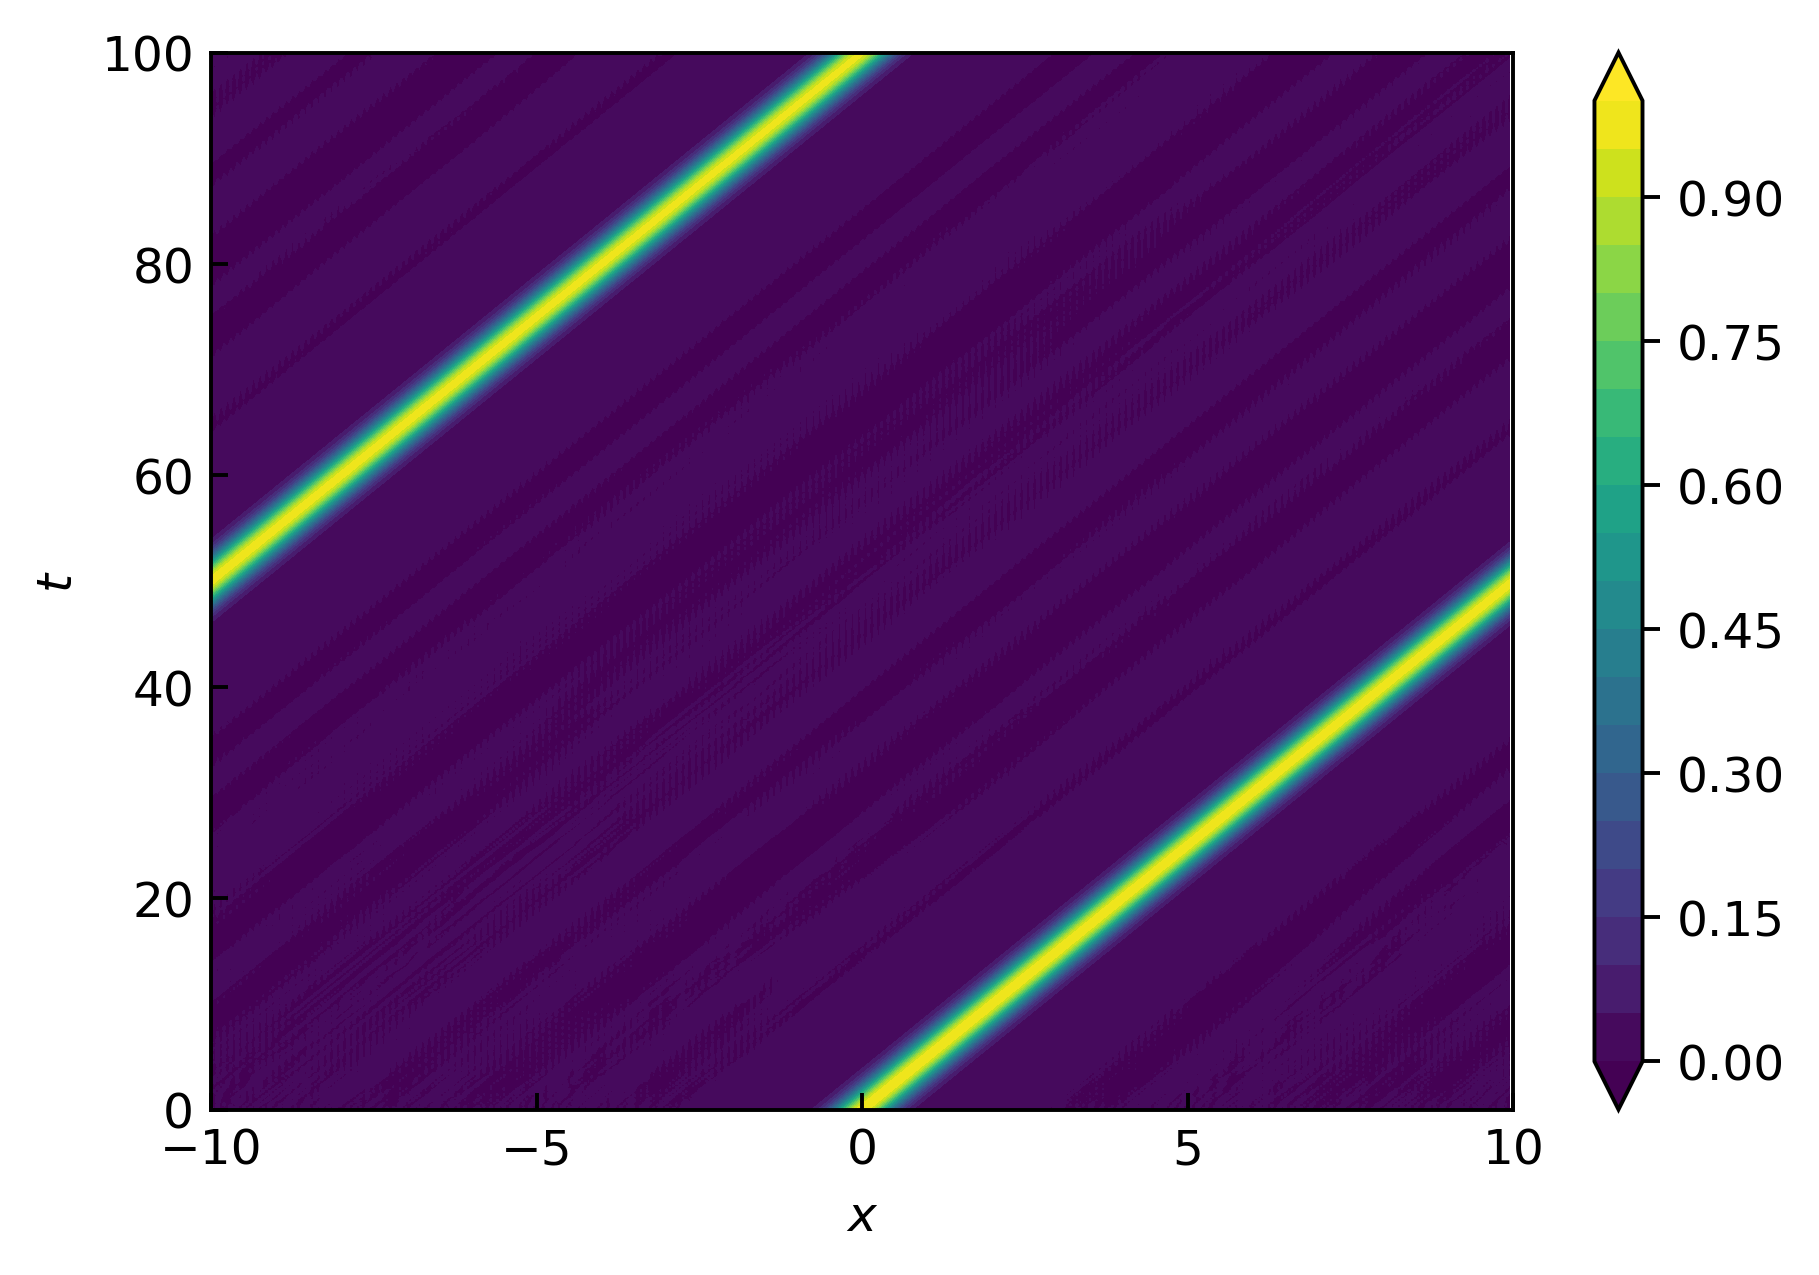

In [4]:
plt.figure(dpi=350)
plt.contourf(X,T,Q,levels=np.arange(0,1+0.05,0.05),extend='both')
plt.xlim(min(X),max(X)+Dx)
plt.ylim(min(T),max(T))
plt.xlabel('$x$',fontsize=10)
plt.ylabel('$t$',fontsize=10)
plt.tick_params(direction='in')
plt.colorbar()
plt.show()

where
\begin{align*}
    \text{wave velocity}\ c &= 0.2 \\
    \text{spatial interval}\ \Delta x &= 0.05 \\
    \text{timestep}\ \Delta t &= 0.005.
\end{align*}

## 2D non-linear advection

\begin{align*}
   \frac{\mathrm{D}}{\mathrm{D}t}q(x,y,t) &= 0 \\
   \frac{\partial q}{\partial t} +u\frac{\partial q}{\partial x}+v\frac{\partial q}{\partial y} &= 0 .
\end{align*}
where the velocity field is a counterclockwise UCM:
\begin{align*}
   u = -\Omega y, \qquad v = \Omega x.
\end{align*}

Setting yp default parameters

In [5]:
Omg     = 0.1
L       = 10
N       = 2**6
X       = np.linspace(-L,L,N+1)[0:-1]
Dx      = X[1]-X[0]
Y       = np.transpose(X)
[Xg,Yg] = np.meshgrid(X,Y)
U       = -Omg*Yg
V       = Omg*Xg

Define initial field

In [6]:
Dt = 50*Omg/N
T  = np.arange(0,2*(np.pi/Omg)+Dt,Dt)
# T  = np.arange(0,201*Dt,Dt)
Q0 = np.zeros((N,N))
s  = 0.6
for i in range (N):
    for j in range (N):
        r = np.sqrt((X[i]-L/3)**2+(Y[j])**2)
        if r/s < np.pi:
            Q0[j,i] = (np.cos(r/s)+1)
Q = Q0

Integrating

In [7]:
def adv(t,Q):
    Nx = len(X)
    Ny = len(Y)
    Qx = np.zeros_like(Q)
    Qy = np.zeros_like(Q)
    for i in range(Ny):
        Qx[i,:] = nm.NDiffFft(X,Q[i,:])
    for j in range(Nx):
        Qy[:,j] = nm.NDiffFft(Y,Q[:,j])
    Qt = -(U*Qx+V*Qy)
    return Qt


## True solution
def QAna(t):
    Qt = np.zeros_like(Q)
    Rx = L/3*np.cos(Omg*t)
    Ry = L/3*np.sin(Omg*t)
    s  = 0.6
    for i in range (N):
        for j in range (N):
            r = np.sqrt((X[i]-Rx)**2+(Y[j]-Ry)**2)
            if r/s < np.pi:
                Qt[j,i] = (np.cos(r/s)+1)
    return Qt

## Numerical solution
E = np.zeros_like(T)
P = np.zeros_like(T)
for t in range(len(T)):
    Q    = nm.NIntgRk4(T[t],Q,Dt,adv)
    E[t] = np.sum((Q-QAna(T[t]))**2)/N**2
    P[t] = np.amax(Q)

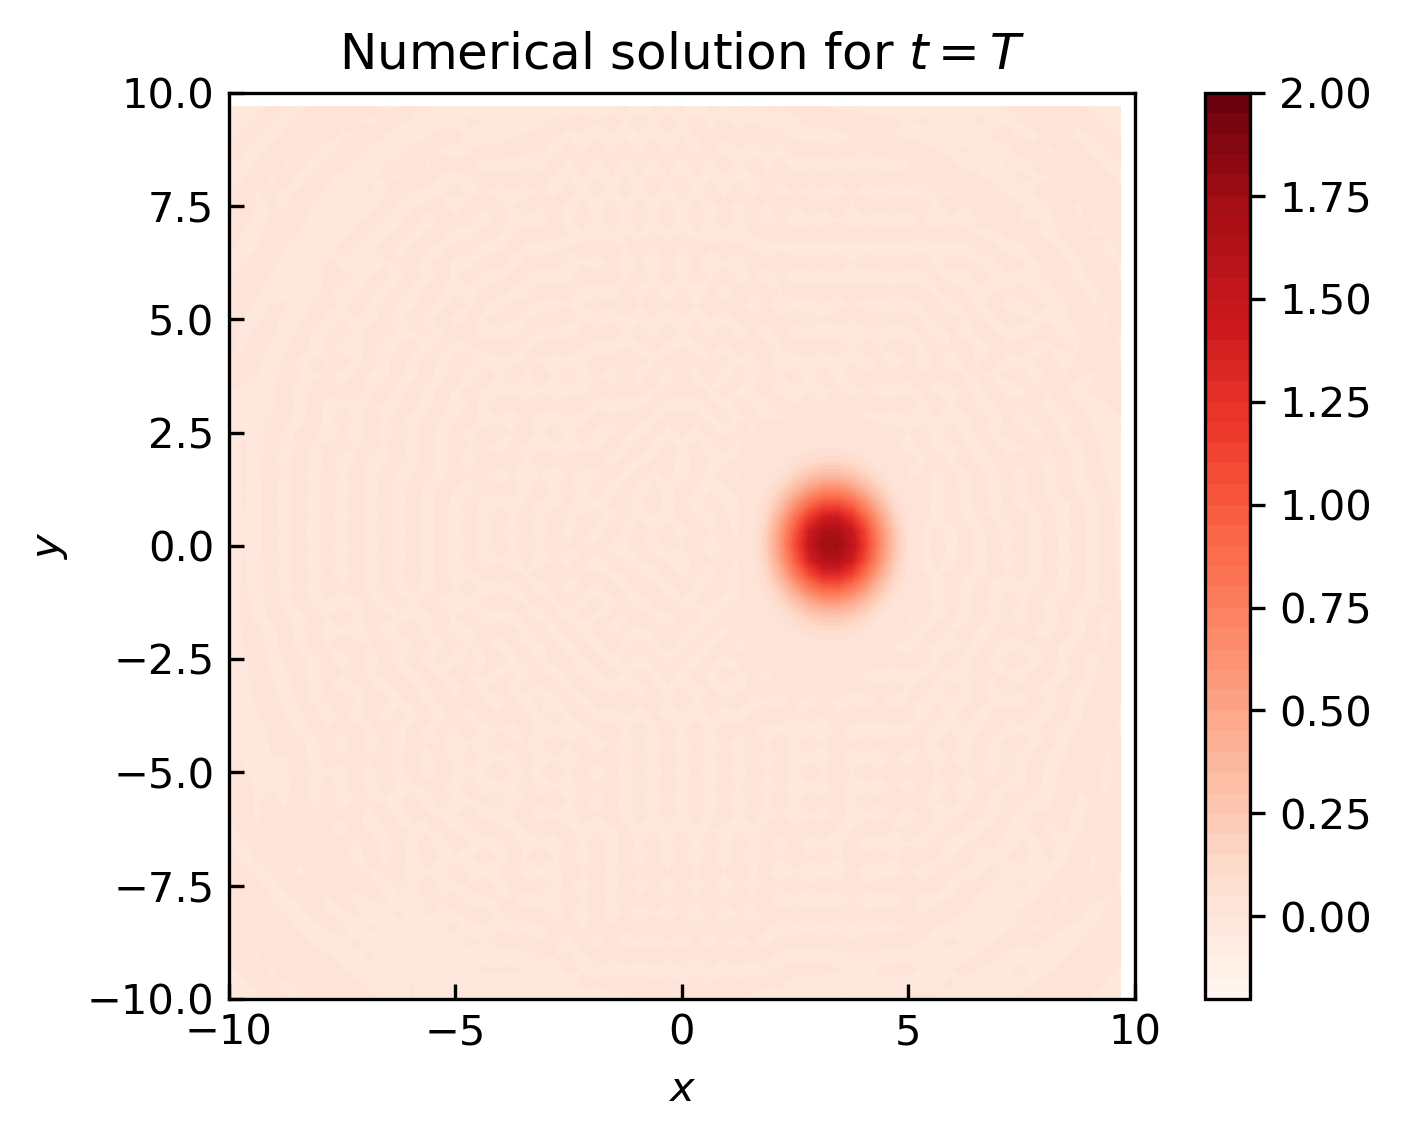

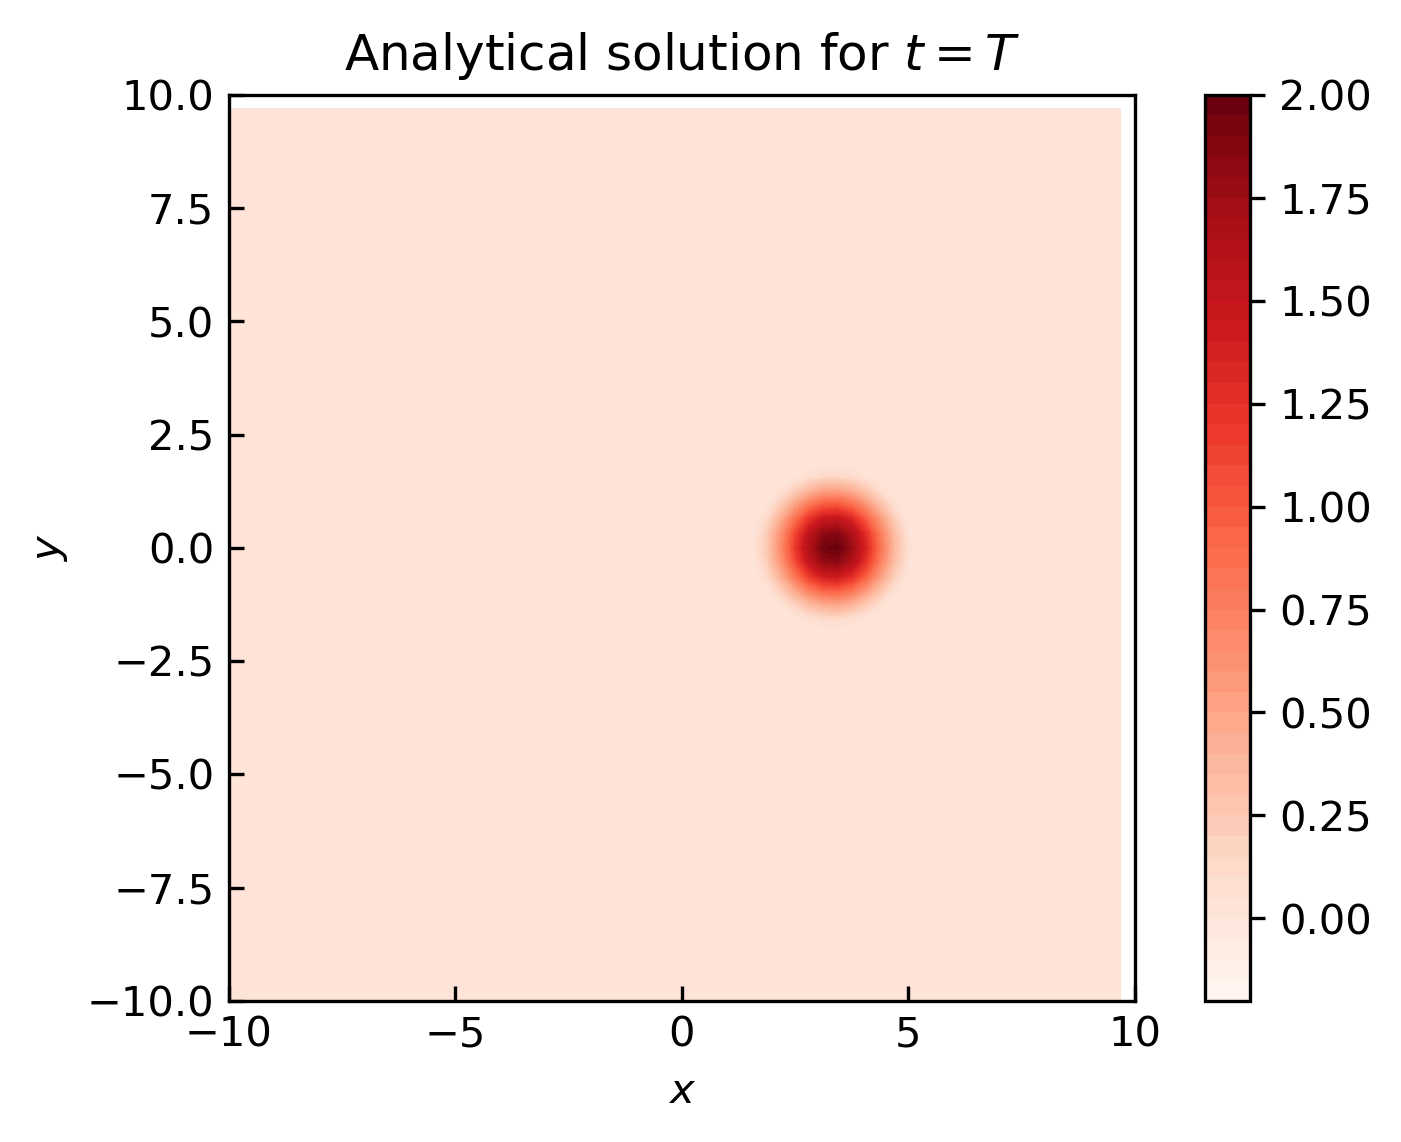

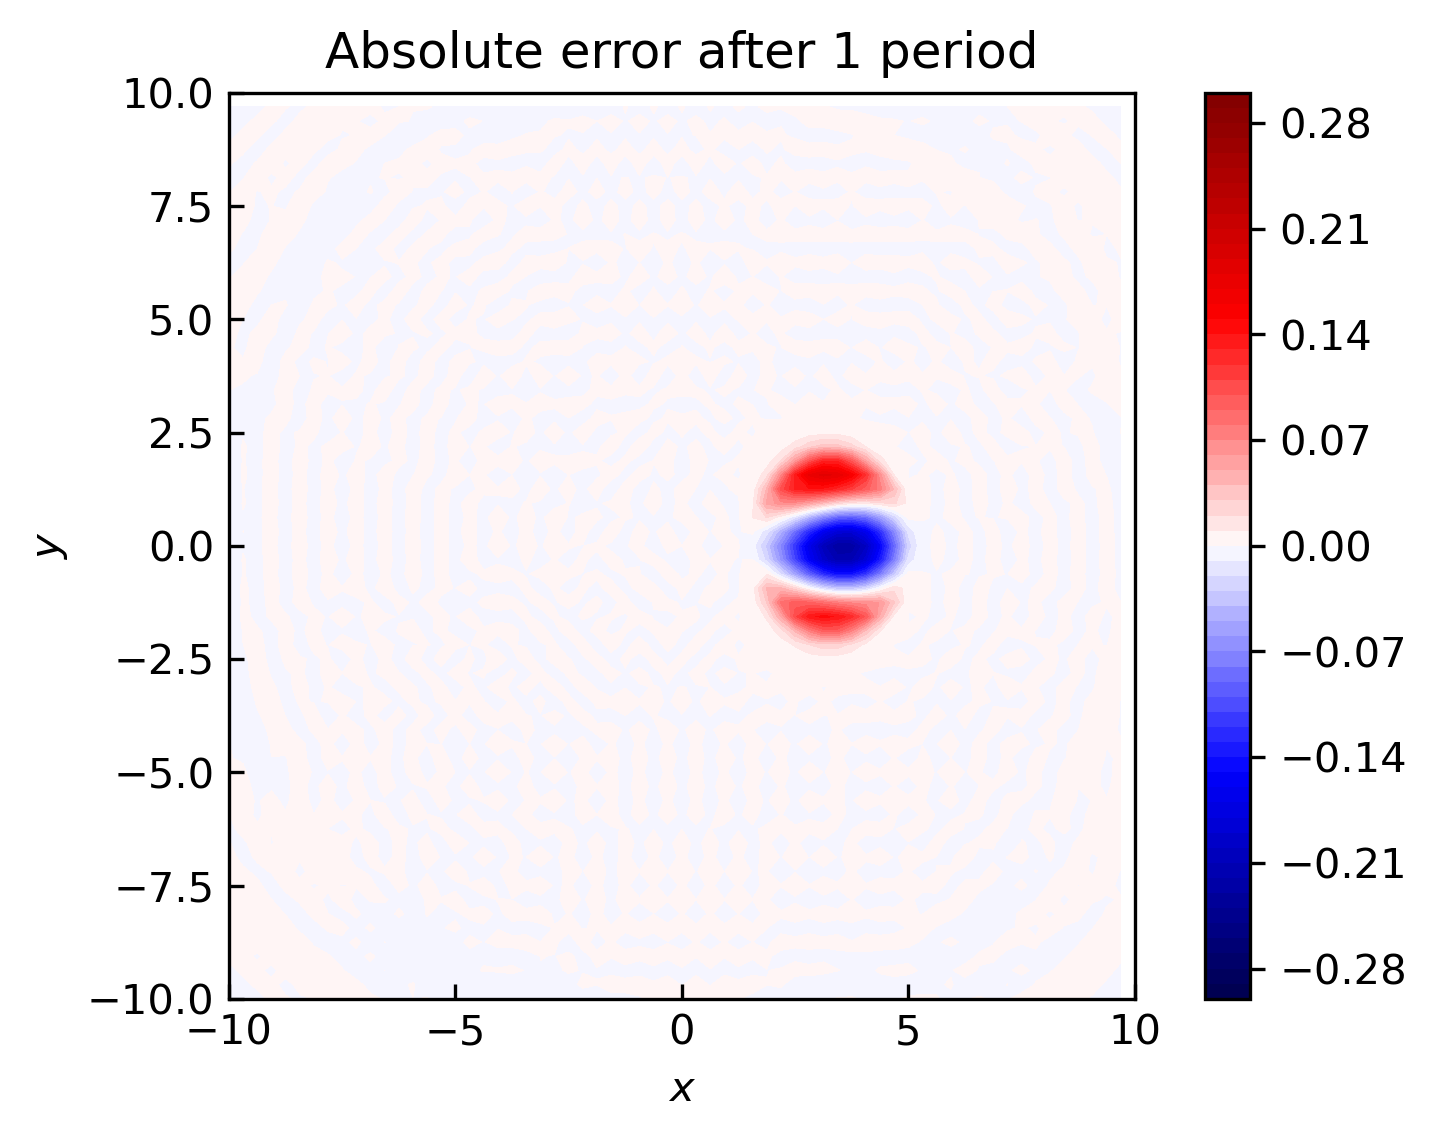

In [8]:
## Numerical solution
plt.figure(dpi=300)
plt.contourf(X,Y,Q,levels=np.arange(-0.2,2+0.05,0.05),cmap=cm.Reds)
plt.axis('scaled')
plt.xlim(-L,L)
plt.ylim(-L,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Numerical solution for $t=T$')
plt.colorbar()
plt.tick_params(direction='in')
plt.show()

## Analytical solution
plt.figure(dpi=300)
plt.contourf(X,Y,QAna(T[t]),levels=np.arange(-0.2,2+0.05,0.05),cmap=cm.Reds)
plt.axis('scaled')
plt.xlim(-L,L)
plt.ylim(-L,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Analytical solution for $t=T$')
plt.colorbar()
plt.tick_params(direction='in')
plt.show()

## Error
plt.figure(dpi=300)
plt.contourf(X,Y,Q-QAna(T[t]),levels=np.arange(-0.3,0.3+0.01,0.01),cmap=cm.seismic)
plt.axis('scaled')
plt.xlim(-L,L)
plt.ylim(-L,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error after 1 period')
plt.colorbar()
plt.tick_params(direction='in')
plt.show()

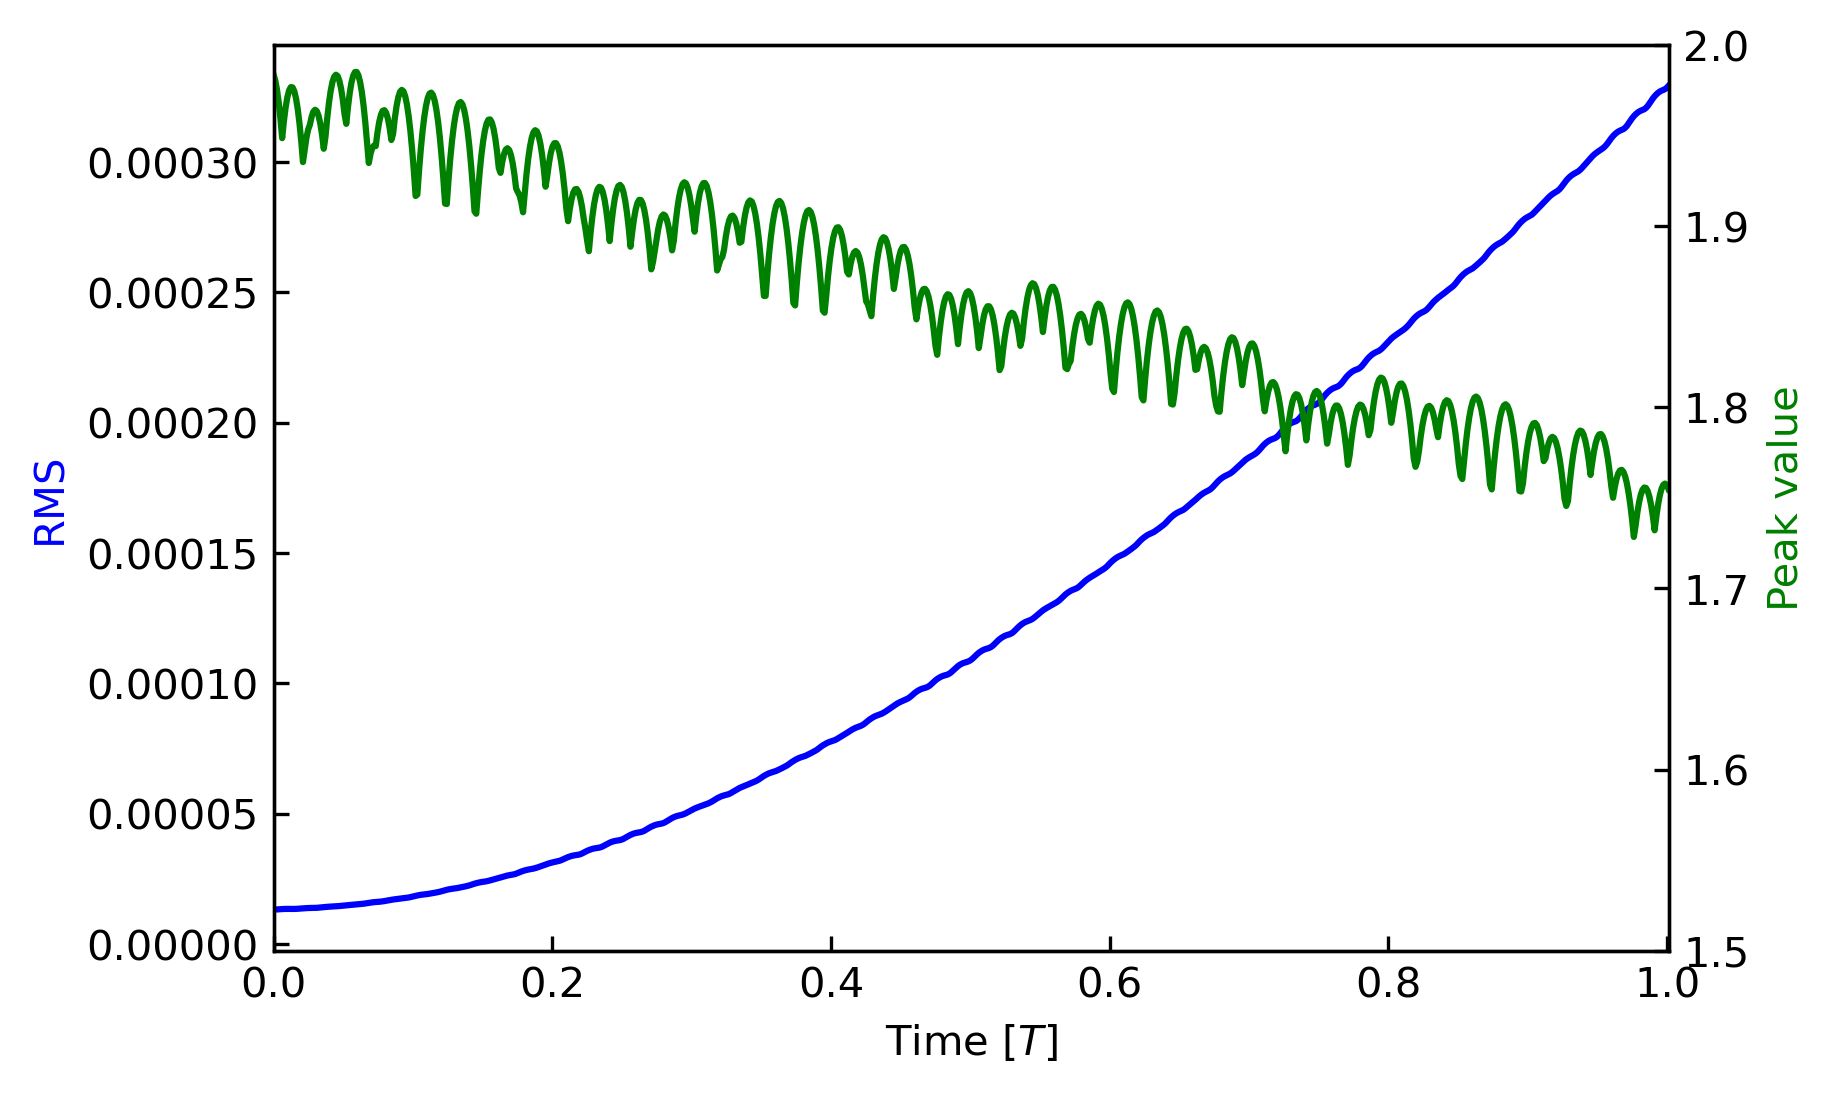

In [9]:
## Error accumulation
fig, ax1 = plt.subplots(dpi=300)
ax2 = ax1.twinx()
ax1.plot(T/(2*np.pi/Omg),E,color='b')
plt.ylim(0,0.0004)
ax2.plot(T/(2*np.pi/Omg),P,color='g')
plt.ylim(1.5,2)
plt.xlim(0,max(T/(2*np.pi/Omg)))
ax1.set_ylabel('RMS',color='b')
ax2.set_ylabel('Peak value',color='g')
ax1.set_xlabel('Time [$T$]')
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')
plt.show()